In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('globalterrorismdb_0718dist.csv')
data = pd.DataFrame(data)

/usr/local/lib/python3.4/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5,32,34,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
G1_data = data.loc[data['iyear']==2003]
G2_data = data.loc[data['iyear']==2004]

In [4]:
import networkx as nx
import random
from networkx.algorithms.approximation import clique
def create_graph(G_data):
    G = nx.Graph()
    for i in range(0,G_data.shape[0]):
        curr_event = G_data['eventid'].iloc[i]
        G.add_node(curr_event)
        if (pd.isnull(G_data['related'].iloc[i])!=True):
            reletad_events = list(map(int,G_data['related'].iloc[i].split(', ')))
            G.add_nodes_from(reletad_events)
            for related_event in reletad_events:
                G.add_edge(curr_event, related_event)
    
    c_table = []
    G.remove_nodes_from(list(nx.isolates(G)))
    G.remove_edges_from(G.selfloop_edges())
    comp = sorted(list(nx.connected_component_subgraphs(G)),key=len)
    nx.set_node_attributes(comp[-1],len(clique.max_clique(comp[-1])),'c_size')
    nx.set_node_attributes(comp[-1],0,'c_id')
    c_table.append(len(clique.max_clique(comp[-1])))
    nx.set_edge_attributes(comp[-1],False,'bridge')

    new_G = comp[-1]
    del comp[-1]
    for i in range(0,4):
        r = random.randint(1,3)
        old_nodes = list(new_G.nodes)
        new_G.add_nodes_from(comp[-1],c_size=len(clique.max_clique(comp[-1])),c_id=i+1)
        c_table.append(len(clique.max_clique(comp[-1])))
        for edge in list(comp[-1].edges):
            new_G.add_edge(edge[0],edge[1],bridge=False)
        for j in range(0,r):
            r_e1 = random.randint(0,len(list(comp[-1].nodes))-1)
            r_e2 = random.randint(0,len(old_nodes)-1)
            new_G.add_edge(old_nodes[r_e2],list(comp[-1].nodes)[r_e1],bridge = True)
        del comp[-1]
    return new_G, c_table

In [5]:
G1, c_table_1 = create_graph(G1_data)
G2, c_table_2 = create_graph(G2_data)

In [6]:
print(nx.info(G1))
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 35
Number of edges: 129
Average degree:   7.3714
Name: 
Type: Graph
Number of nodes: 31
Number of edges: 91
Average degree:   5.8710


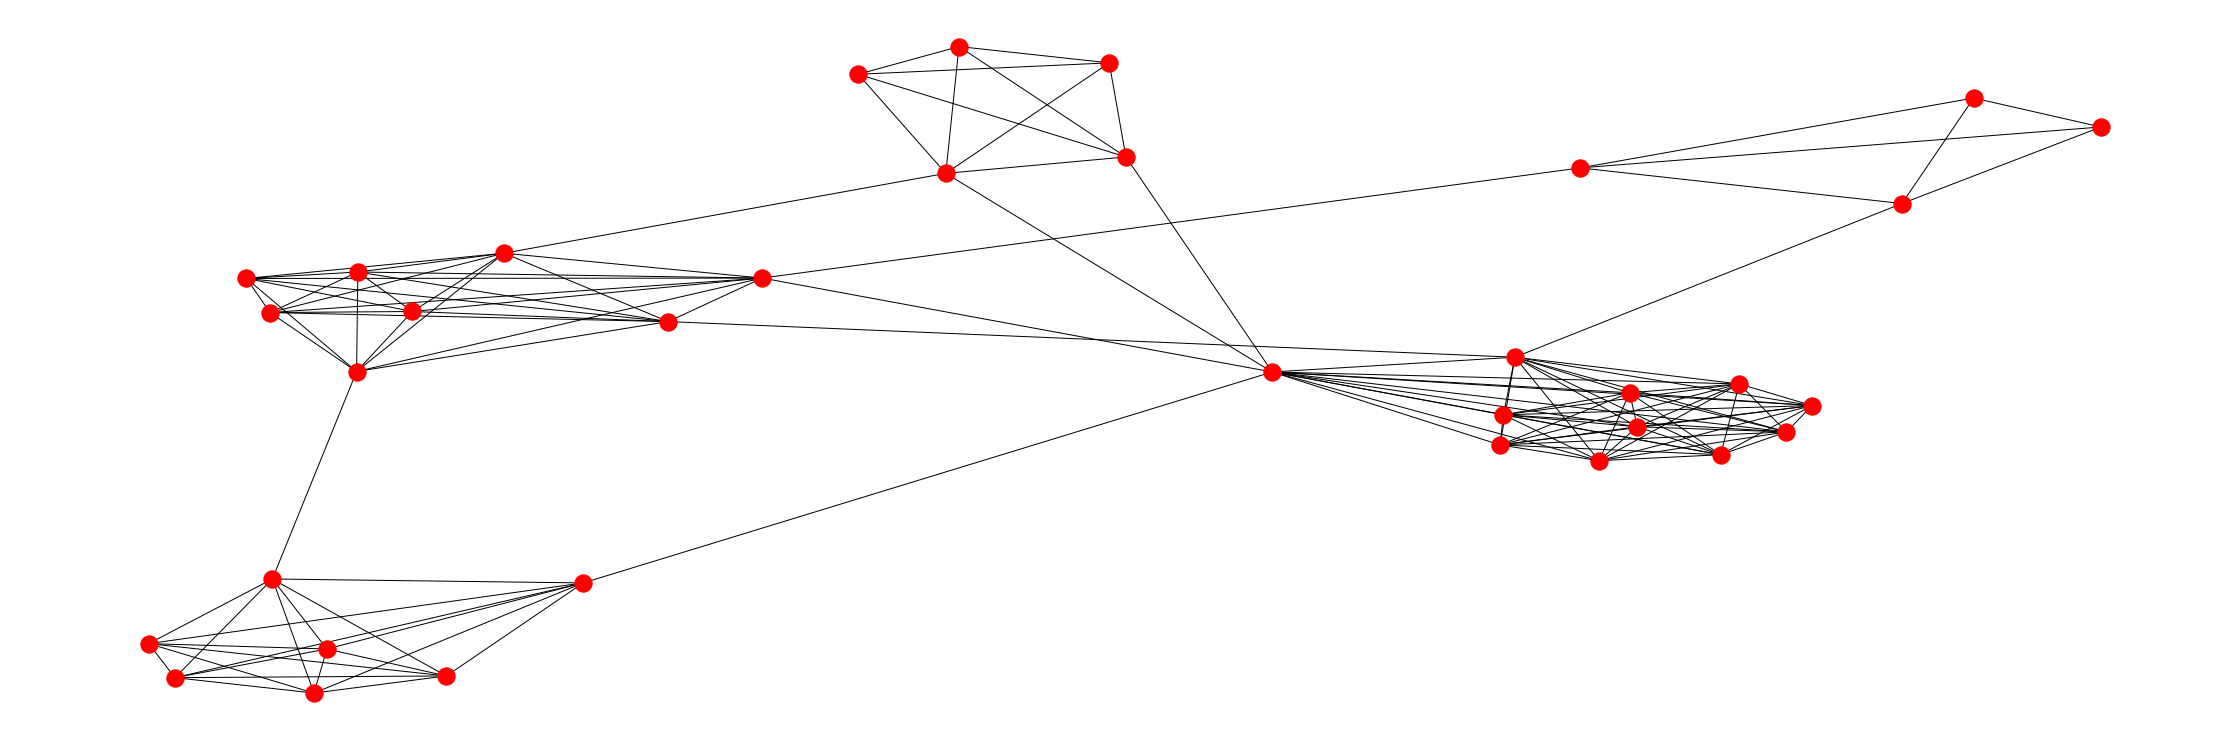

In [7]:
import pylab as plt
plt.figure(figsize=(30,10))
nx.draw(G1)
plt.show()

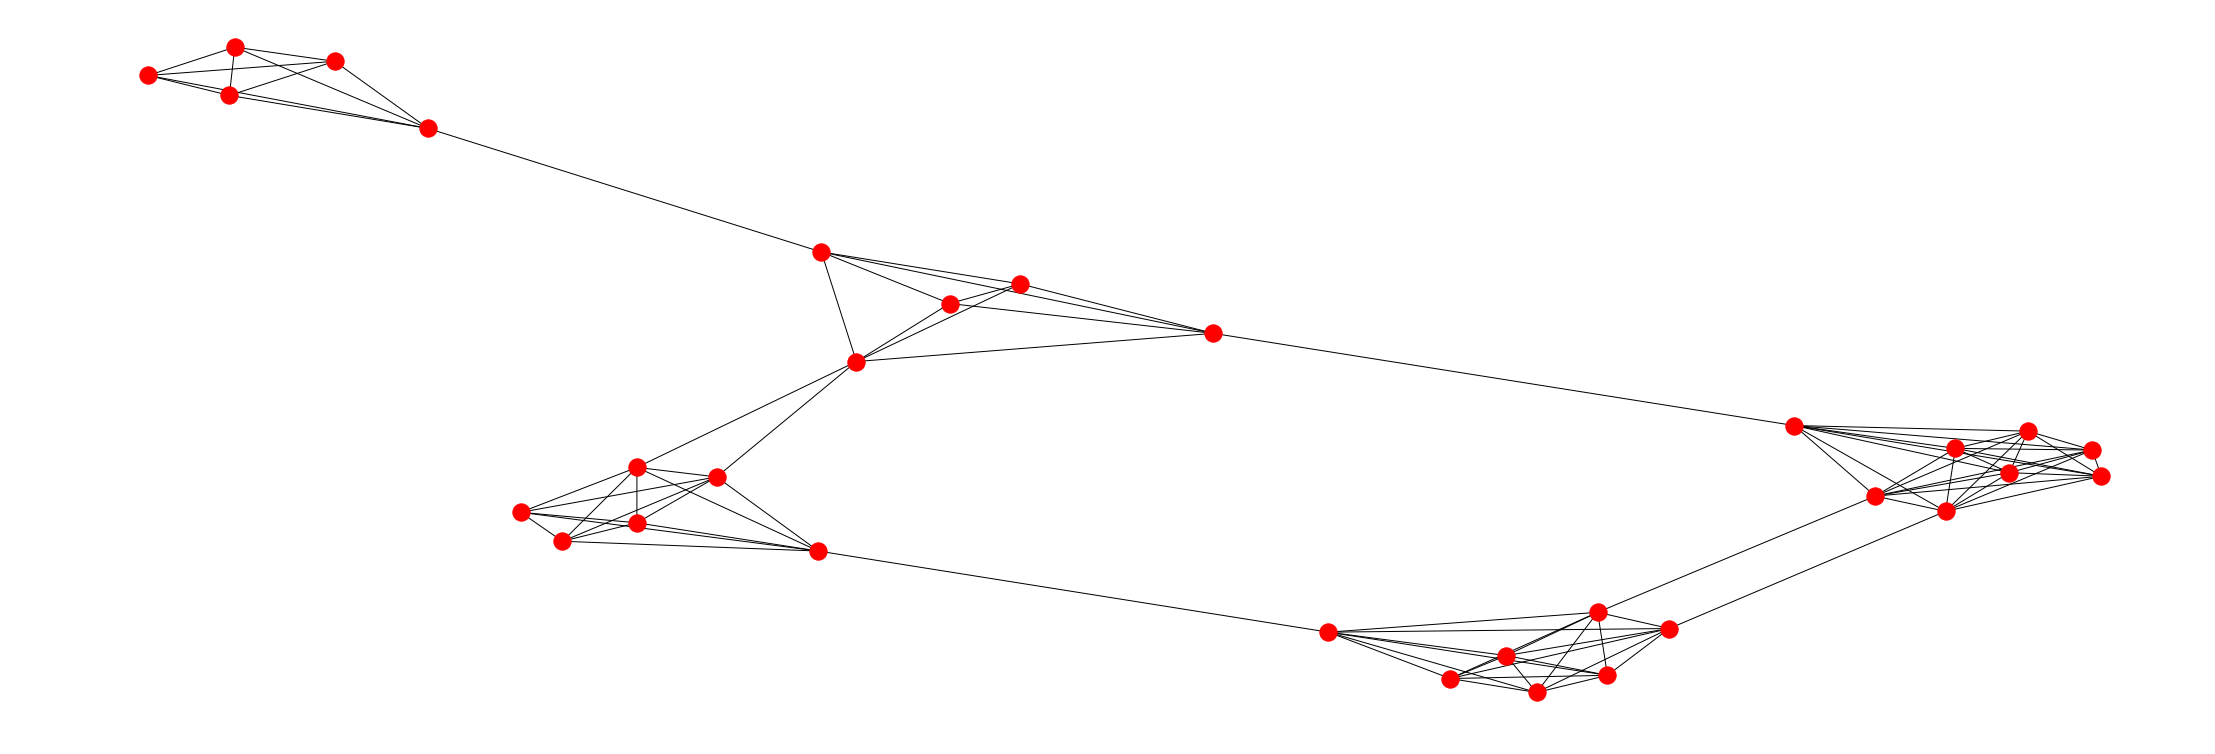

In [8]:
plt.figure(figsize=(30,10))
nx.draw(G2)
plt.show()

In [9]:
import math

In [10]:
def h(lMin,e,g1,g2,add):
    cost = 0
    E = 0
    V = 0
    if (e[0][1] != 'e'):
        V += 1
    for i in range(0,len(lMin)):
        if(add):
            if(g2.has_edge(lMin[i][1],e[0][1])):
                E += 1
                
            if(e[0][0]!='e'):
                if(g1.has_edge(lMin[i][0],e[0][0])!=g2.has_edge(lMin[i][1],e[0][1])):
                    cost += 1
                    
            else:
                if(g2.has_edge(lMin[i][0],e[0][1])):
                    cost += 1
        else:
            if(g1.has_edge(lMin[i][0],e[0][0])):
                cost += 1
                E -= 1
    return cost, E, V

In [11]:
def GED(g1,g2):
    OPEN = []
    d = nx.density(g2)
    ind=0
    for i in range(0,len(list(g2.nodes))):
        OPEN.append({'l':[[list(g1.nodes)[0],list(g2.nodes)[i]]], 'cost': 0, 'E': 0, 'V': 1})
    OPEN.append({'l':[[list(g1.nodes)[0],'e']], 'cost': 1, 'E': 0, 'V': 0})
    while (True):
        lMin = min(OPEN, key=lambda x:x['cost'])
        OPEN.remove(lMin)
        ind+=1
        used_v = []
        for i in range(0,len(lMin['l'])):
            if(lMin['l'][i][1]!='e'):
                used_v.append(lMin['l'][i][1])
        free_v = [x for x in list(g2.nodes) if x not in used_v]

        if (len(lMin['l'])==max(len(g1.nodes),len(g2.nodes))):
            return lMin
        else:

            old_cost = lMin['cost']
            if(lMin['V'] < len(list(g1.nodes()))):
                for w in free_v:
                    f = h(lMin['l'], [[list(g1.nodes)[lMin['V']],w]],g1,g2,True)
                    new_E = lMin['E'] + f[1]
                    new_V = lMin['V'] + f[2]
                    new_cost = old_cost + f[0]
                    for i in range(0, len(OPEN)):
                        if(len(OPEN[i]['l']) < len(lMin['l']+[[list(g1.nodes)[lMin['V']],w]])):
                            OPEN.insert(i,{'l':lMin['l']+[[list(g1.nodes)[lMin['V']],w]], 'cost':new_cost, 'E': new_E, 'V': new_V})
                            break
                        if(i==len(OPEN)-1):
                            OPEN.append({'l':lMin['l']+[[list(g1.nodes)[lMin['V']],w]], 'cost':new_cost, 'E': new_E, 'V': new_V})

                f = h(lMin['l'],[[list(g1.nodes)[lMin['V']],'e']],g1,g2,False)
                new_E = lMin['E'] + f[1]
                new_V = lMin['V'] + f[2]
                new_cost = old_cost + f[0]
                new_err = new_cost
                for i in range(0, len(OPEN)):
                    if(len(OPEN[i]['l']) < len(lMin['l']+[[list(g1.nodes)[lMin['V']],'e']])):
                        OPEN.insert(i,{'l':lMin['l']+[[list(g1.nodes)[lMin['V']],'e']], 'cost':new_cost+1, 'E': new_E, 'V': new_V})
                        break
                    if(i==len(OPEN)-1):
                        OPEN.append({'l':lMin['l']+[[list(g1.nodes)[lMin['V']],'e']], 'cost':new_cost+1, 'E': new_E, 'V': new_V})

            else:
                for w in free_v:
                    f = h(lMin['l'],[['e',w]],g1,g2,True)
                    new_E = lMin['E'] + f[1]
                    new_V = lMin['V'] + f[2]
                    new_cost = old_cost + f[0]
                    new_err = new_cost
                    for i in range(0, len(OPEN)):
                        if(len(OPEN[i]['l']) < len(lMin['l']+[['e',w]])):
                            OPEN.insert(i,{'l':lMin['l']+[['e',w]], 'cost':new_cost+1, 'E': new_E, 'V': new_V})
                            break
                        if(i==len(OPEN)-1):
                            OPEN.append({'l':lMin['l']+[['e',w]], 'cost':new_cost+1, 'E': new_E, 'V': new_V})

In [12]:
g1 = nx.Graph()
g2 = nx.Graph()

g1.add_edge(1,2)
g1.add_edge(2,3)
g1.add_edge(4,6)
g1.add_edge(1,5)
g1.add_edge(2,6)
g1.add_edge(3,7)

g2.add_edge(1,2)
g2.add_edge(2,3)
g2.add_edge(4,6)
g2.add_edge(1,5)
g2.add_edge(2,6)
g2.add_edge(3,5)

Пример Работы GED на малых графах

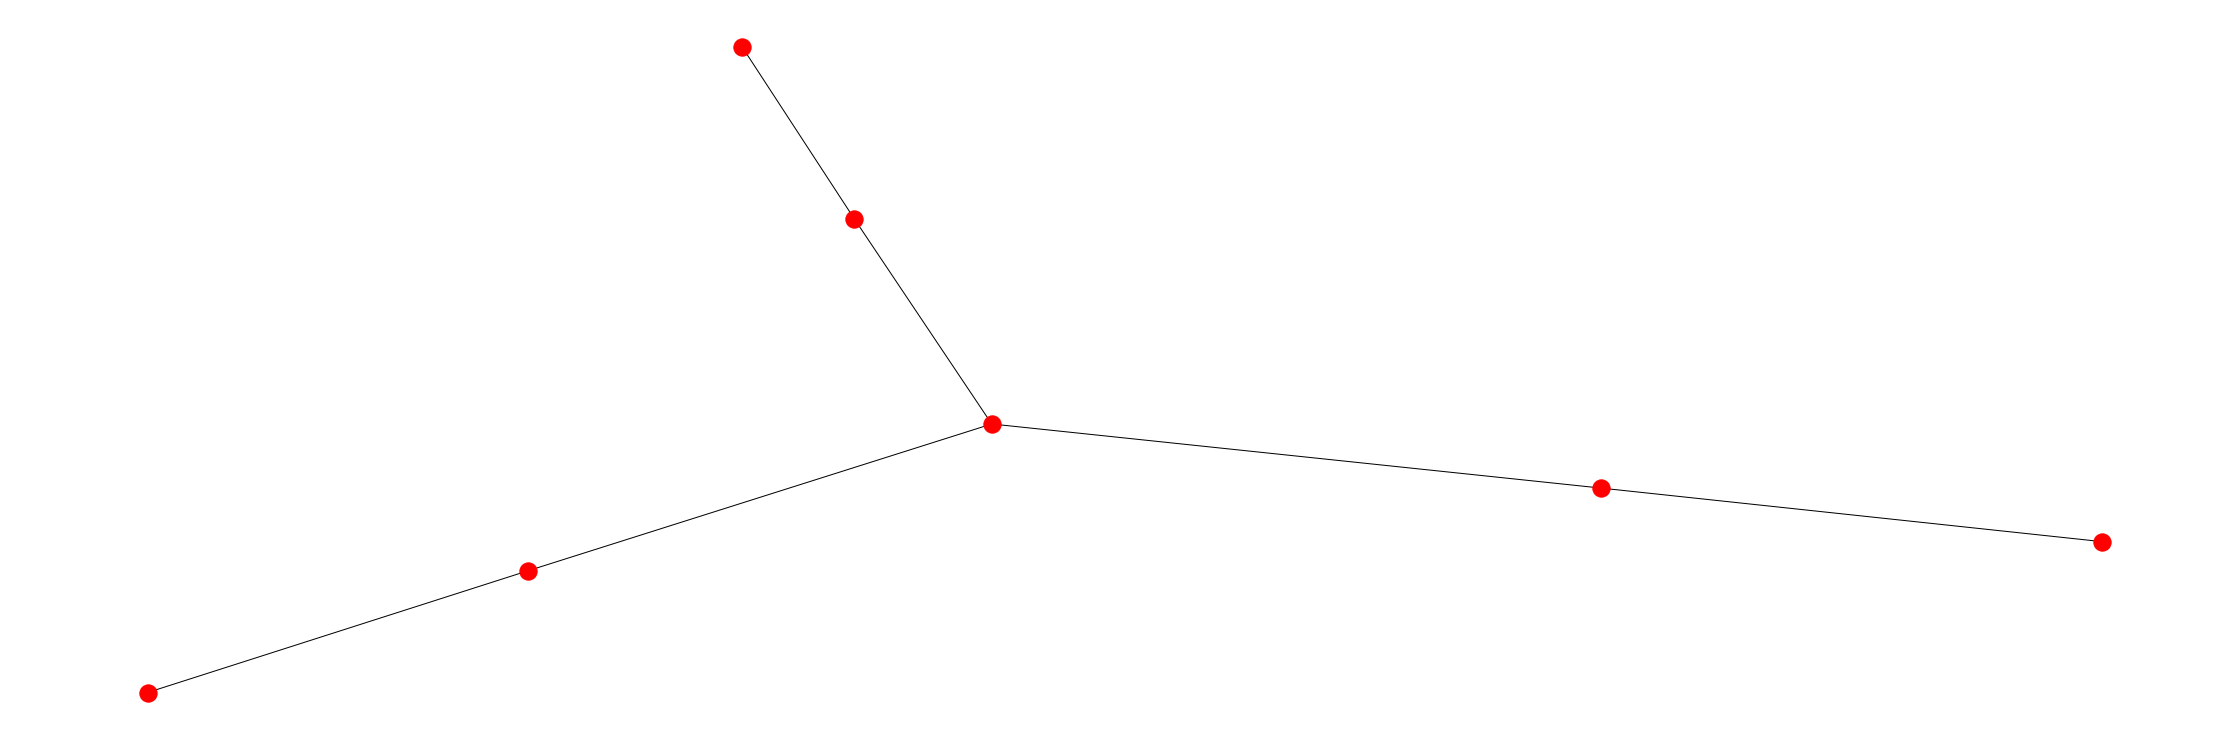

In [13]:
plt.figure(figsize=(30,10))
nx.draw(g1)
plt.show()

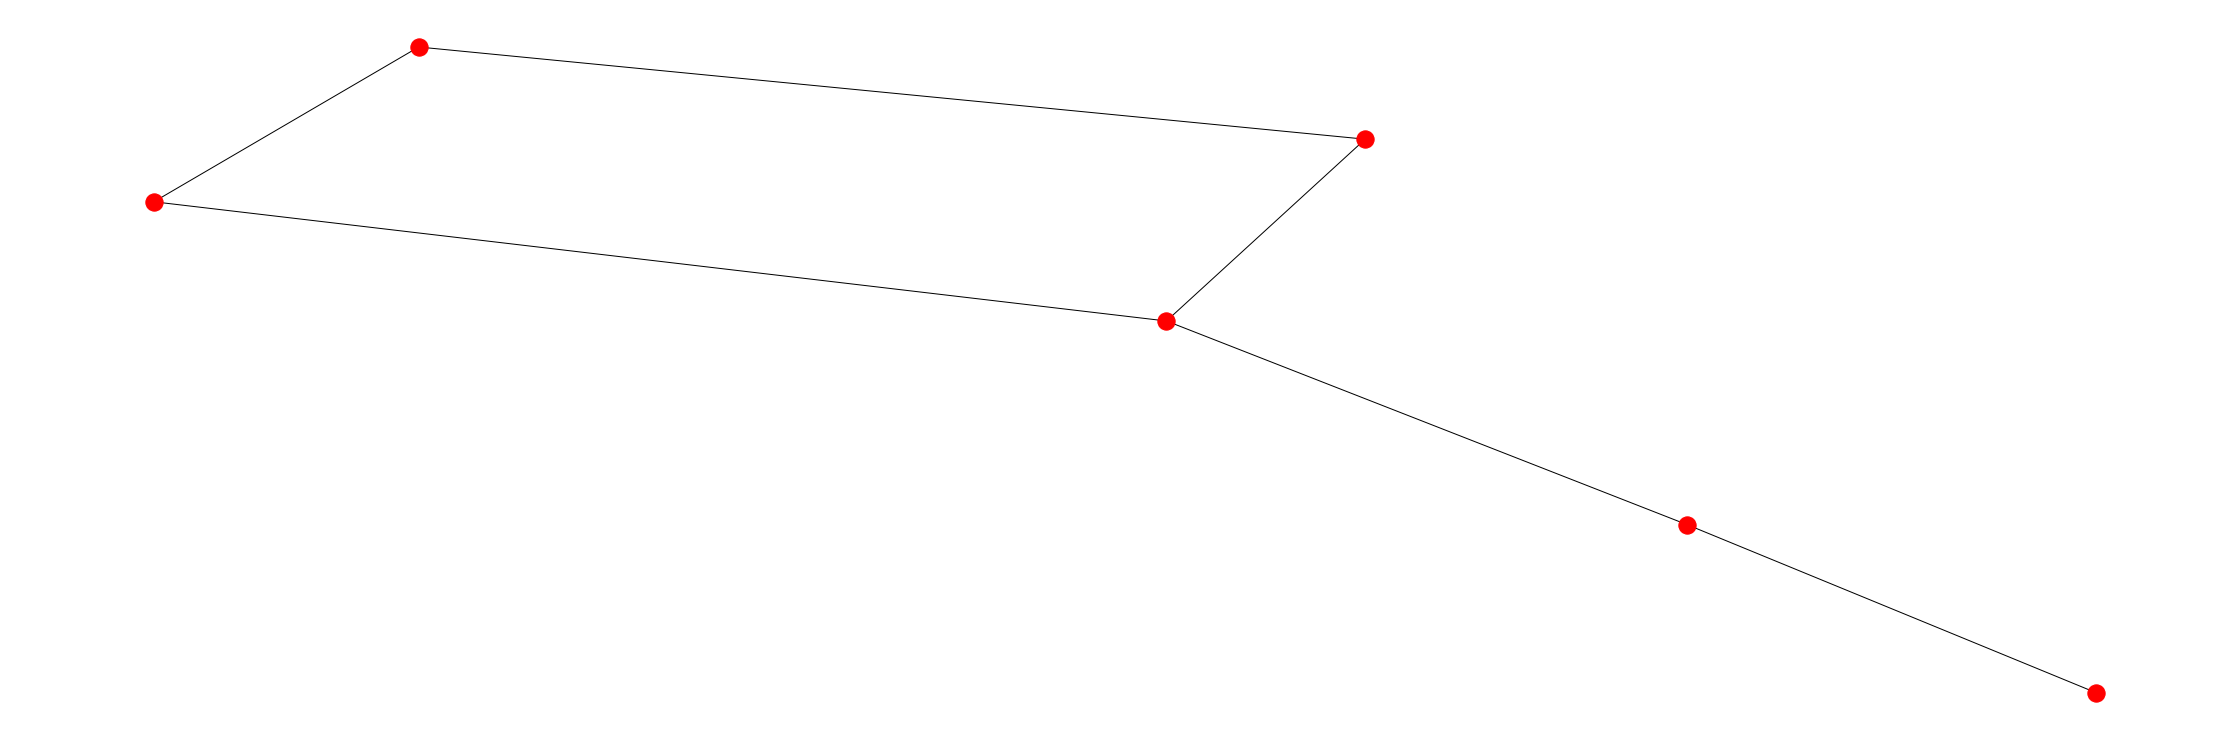

In [14]:
plt.figure(figsize=(30,10))
nx.draw(g2)
plt.show()

In [15]:
ged = GED(g1,g2)
print(ged['l'])
print("cost: ", ged['cost'])

[[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 'e']]
cost:  3


In [16]:
import numpy as np
def Wiener(g):
    index = 0
    n = len(g.nodes)
    node_names = list(g.nodes)
    W = np.ones([n,n])
    for i in range(0,n):
        for j in range(0,n):
            if (i==j):
                W[i][j] = 0
                continue
            if (g.has_edge(node_names[i],node_names[j]) != True):
                W[i][j] = np.inf
    for k in range(0,n):
        for i in range(0,n):
            for j in range(0,n):
                new_w = W[i][k] + W[k][j]
                if(W[i][j] > new_w):
                    W[i][j] = new_w
    
    for i in range(0,n):
        for j in range(0,n):
            if (W[i][j] != np.inf):
                index += W[i][j]
    return index/2, W

In [17]:
index1, W1 = Wiener(G1)
index2, W2 = Wiener(G2)

In [18]:
print('Wiener index for Graph1: ',index1)
print('Wiener index for Graph2: ',index2)

Wiener index for Graph1:  1478.0
Wiener index for Graph2:  1479.0


In [19]:
def eccentricity_diametr_periphery(g,W):
    eccentricity = np.zeros(np.shape(W)[0])
    diametr = 0
    periphery = []
    for i in range(0,np.shape(W)[0]):
        for j in range(0,np.shape(W)[0]):
            if (W[i][j]!=np.inf and W[i][j]>eccentricity[i]):
                eccentricity[i] = W[i][j]
        if (eccentricity[i] > diametr):
            diametr = eccentricity[i]
            periphery = [list(g.nodes)[i]]
        elif (eccentricity[i] == diametr):
            periphery.append(list(g.nodes)[i])
    return eccentricity, diametr, periphery

In [20]:
eccentricity1, diametr1, periphery1 = eccentricity_diametr_periphery(G1, W1)
eccentricity2, diametr2, periphery2 = eccentricity_diametr_periphery(G2, W2)
print('For Graph 1: ')
print('eccentricity = ', eccentricity1)
print('diametr = ', diametr1)
print('periphery = ', periphery1)
print()
print('For Graph 2: ')
print('eccentricity = ', eccentricity2)
print('diametr = ', diametr2)
print('periphery = ', periphery2)

For Graph 1: 
eccentricity =  [ 4.  5.  3.  3.  3.  3.  3.  3.  3.  3.  5.  5.  4.  3.  3.  3.  3.  3.
  3.  3.  3.  3.  3.  3.  5.  4.  5.  4.  5.  5.  4.  5.  4.  5.  5.]
diametr =  5.0
periphery =  [200302000002, 200305160005, 200302000003, 200302000005, 200302180004, 200302180006, 200305160007, 200303080008, 200305160004, 200302000004]

For Graph 2: 
eccentricity =  [ 7.  5.  5.  5.  4.  5.  5.  5.  5.  7.  7.  5.  5.  4.  4.  5.  7.  6.
  7.  7.  7.  7.  6.  6.  6.  5.  5.  5.  4.  4.  5.]
diametr =  7.0
periphery =  [200410160001, 200410160009, 200410160008, 200410160006, 200412060004, 200412060005, 200412060006, 200412060007]


Метрики:

In [21]:
from scipy import stats
m1 = stats.mode(eccentricity1).mode/stats.mode(eccentricity1).count

m2 = stats.mode(eccentricity2).mode/stats.mode(eccentricity2).count

print(math.fabs((m1-m2)))


0.1992481203007519


In [22]:
print(math.fabs(diametr1/len(G1.nodes) - diametr2/len(G2.nodes)))

0.08294930875576037


In [23]:
print(math.fabs(diametr1*len(periphery1)/len(G1.nodes) - diametr2*len(periphery2)/len(G2.nodes)))

0.37788018433179715


In [24]:
def girth(g):
    G = np.inf
    for v in g.nodes:
        S = []
        R = [v]
        Parent = {v : None}
        D = {v : 0}
        while (len(R) != 0):
            x = R[0]
            S.append(x)
            R.remove(x)
            N = list(g.neighbors(x))
            if (Parent[x] in N):
                N.remove(Parent[x])
            for y in N:
                if y not in S:
                    Parent.update({y : x})
                    D.update({y : D[x]+1})
                    R.append(y)
                else:
                    G = min(G, D[x] + D[y] + 1)
    return G

In [25]:
print(girth(G1))
print(girth(G2))

3
3


In [26]:
print(math.fabs(girth(G1)/len(G1.edges) - girth(G2)/len(G2.edges)))

0.009711219013544596


Метрика индекс Винера

In [27]:
print(2*(index1/(len(G1.nodes)*diametr1) + index2/(len(G2.nodes)*diametr2))/(index1/(len(G1.nodes)*diametr1) * index2/(len(G2.nodes)*diametr2)))

0.530248009801


Табличные значения индекса Хосойи для клик:

In [28]:
c_hosoya_index = [1, 1, 2, 4, 10, 26, 76, 232, 764, 2620, 9496, 35696, 140152, 568504, 2390480, 10349536, 46206736, 211799312, 997313824, 4809701440, 23758664096, 119952692896, 618884638912, 3257843882624, 17492190577600, 95680443760576, 532985208200576]

In [29]:
def p(g,k,c_table,c_hosoya_index):
    if (k > len([edge for edge in g.edges.data() if edge[2]['bridge']])):
        return 0
    if(len([edge for edge in g.edges.data() if edge[2]['bridge']]) == 0):
        cost = 1
        for c in c_table:
            cost *= c_hosoya_index[c-1]
        return cost
    e = [edge for edge in g.edges.data() if edge[2]['bridge']][0]
    v, w = e[0],e[1]
    g1 = g.copy()
    g2 = g.copy()
    g1.remove_edge(v,w)
    r = p(g1,k,c_table,c_hosoya_index)
    v_c_id = g2.node[v]['c_id']
    v_c_size = g2.node[v]['c_size']
    w_c_id = g2.node[w]['c_id']
    w_c_size = g2.node[w]['c_size']
    g2.remove_node(v)
    g2.remove_node(w)
    c_table[v_c_id] = v_c_size -1
    c_table[w_c_id] = w_c_size -1
    q = p(g2,k-1,c_table,c_hosoya_index)
    return (r+q)

In [30]:
def Hosoya(g, c_table, c_hosoya_index):
    index = 1
    bridge_g = nx.Graph()
    for bridge in [edge for edge in g.edges.data() if edge[2]['bridge']]:
        bridge_g.add_edge(bridge[0],bridge[1])
    for i in range(0,len(nx.maximal_matching(bridge_g))+1):
        t_c_table =  c_table.copy()
        index += p(g,i,t_c_table,c_hosoya_index)
    return index

In [31]:
H1 = Hosoya(G1,c_table_1, c_hosoya_index)
H2 = Hosoya(G2,c_table_2, c_hosoya_index)
print('Graph 1 Hosoya index: ', H1)
print('Graph 2 Hosoya index: ', H2)

Graph 1 Hosoya index:  24742389761
Graph 2 Hosoya index:  216719361


In [34]:
print(math.fabs(H1/(np.prod(c_table_1)*len([edge for edge in G1.edges.data() if edge[2]['bridge']]))- H2/(np.prod(c_table_2)*len([edge for edge in G2.edges.data() if edge[2]['bridge']]))))

219459.9473843022
